In [1]:
import snscrape.modules.twitter as sntwitter
import csv
import pandas as pd
import time
import re  
from wordcloud import WordCloud# Join the different processed titles together.
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore", DeprecationWarning)# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
import os
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import gensim
from gensim import corpora, models, similarities
import logging
import tempfile
from nltk.corpus import stopwords
from string import punctuation
from collections import OrderedDict
import pyLDAvis.gensim
import tempfile
import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet
from IPython.display import display
from apyori import apriori
import spacy
from vaderSentiment import vaderSentiment
from datetime import datetime, timedelta
import pandas_bokeh
from nrclex import NRCLex

%matplotlib inline

init_notebook_mode(connected=True) #do not miss this line
warnings.filterwarnings("ignore")

# Search Query

In [2]:
#############################################################
#############################################################
##                                                         ##
##  INPUT SEARCH QUERY TO SCRAPE TWEETS AND NAME CSV FILE  ##
##                                                         ##
#############################################################
#############################################################


keyword = '#scotus'

maxTweets = 250


#Open/create a file to append data to
dt = datetime.now().strftime("%d%b%Y_%H%M") # ("%d_%b_%Y_%H_%M_%S")  --  add %S for seconds
csvFile = open('twitter_data/twitter_{}_{}_{}.csv'.format(keyword, maxTweets, dt), 'a', newline='', encoding='utf8')
csvWriter = csv.writer(csvFile)
csvWriter.writerow(['id','date','tweet']) 

for i,tweet in enumerate(sntwitter.TwitterSearchScraper(keyword).get_items()) :
        if i > maxTweets :
            break      
        csvWriter.writerow([tweet.id, tweet.date, tweet.content])
csvFile.close()

In [3]:
##################################################
# SPECIFY ADDITIONAL WORDS AND ARTEFACTS TO DELETE
##################################################

delete_words = ["amp", "https", "http", "n't", "'s", "'m", "www", "nan"]

# Load data

In [4]:
filename = 'twitter_data/twitter_{}_{}_{}.csv'.format(keyword, maxTweets, dt)

In [5]:
# filename = 'twitter_data/ggggggggg.csv'

# EDA

In [6]:
pd.set_option('max_colwidth',150)
tweets = pd.read_csv(filename)
tweets.columns = ['ID', 'Datetime', 'Text']
# Convert tweets to strings and lower case
tweets['Text'] = tweets['Text'].astype(str)
tweets['Text'] = tweets['Text'].map(lambda x: x.lower())
print("Total tweets:   ", len(tweets))
print("Start datetime (UTC): ", tweets.Datetime.min())
print("End datetime (UTC):   ", tweets.Datetime.max())

# tweets

Total tweets:    251
Start datetime (UTC):  2020-11-22 02:19:44+00:00
End datetime (UTC):    2020-11-22 11:57:36+00:00


# Filter data by date

In [7]:
datetime.utcnow()

datetime.datetime(2020, 11, 22, 11, 58, 11, 808021)

In [8]:
# yesterday_datetime = datetime.utcnow() - timedelta(2)  # datetime 24 hours earlier (1)
# yesterday_datetime = yesterday_datetime.strftime("%Y-%m-%d %H:%M:%S")
# tweets = tweets.query('Datetime >= "{}+00:00"'.format(yesterday_datetime))
# print("Starting datetime: ", tweets.Datetime.min())
# print("Total tweets:      ", len(tweets))

# Identify duplicated tweets

In [9]:
duplicated_tweets = tweets.loc[tweets.duplicated(subset = ['Text'], keep = 'first')]
unique_duplicated_tweets = pd.DataFrame(duplicated_tweets['Text']).drop_duplicates(subset = 'Text', keep = 'first')
print("Total duplicated Tweets: ", len(duplicated_tweets))
print("Total unique duplicated Tweets: ", len(unique_duplicated_tweets))

Total duplicated Tweets:  0
Total unique duplicated Tweets:  0


In [10]:
# count duplicated tweets using groupby
dup_tweets = tweets.groupby(tweets.Text.tolist()).size().reset_index().rename(columns={0:'frequency'})
dup_tweets = dup_tweets.query('frequency > 1').sort_values(by ='frequency', ascending = False, inplace = False)
pd.set_option('display.max_rows', len(dup_tweets))

In [11]:
pandas_bokeh.output_notebook()

if len(dup_tweets) > 0:
    dup_tweets.plot_bokeh(kind = 'line',
                      x = 'index',
                      y = 'frequency', 
                      xlabel = 'Tweet',
                      ylabel = 'Frequency',
                      title = 'Number of retweets',
                      figsize = (800, 400),
                      xticks = "")
else:
    pass

Loading BokehJS ...

In [12]:
dup_tweets

,index,frequency


In [13]:
index_num = 978

if index_num in dup_tweets.index: display(dup_tweets['index'].loc[index_num])

# Drop duplicates

In [14]:
# Remove duplicate rows
# tweets.drop_duplicates(subset = ['Text'], keep = 'first', inplace = True)
print("Total tweets without duplicates: ", len(tweets))

Total tweets without duplicates:  251


# Drop rows containing keywords

In [15]:
remove_SPAM = pd.DataFrame()
remove_SPAM = tweets[tweets['Text'].str.contains("hhhhhhhhhhhhh")] 

remove_SPAM_index = remove_SPAM.index.tolist()
tweets.drop(remove_SPAM_index, inplace = True)
tweets.reset_index()
tweets_original = tweets  # for search function below
print("Total tidied replies: ", len(tweets))

Total tidied replies:  251


# Extract hashtags

In [16]:
def search_hashtag(string):
    pat = r'(\w*%s\w*)' % "#"      # find strings containing '#'
    return re.findall(pat, string)

hashtags = pd.DataFrame()  # add hashtags to new dataframe
hashtags['list'] = tweets['Text'].apply(lambda row: search_hashtag(row))  
hashtags_tokenised = pd.DataFrame()  
hashtags_tokenised['hashtags'] = hashtags.apply(lambda x: pd.Series(x['list']),axis=1).stack().reset_index(level=1, drop=True)
total_number_hashtags = len(hashtags_tokenised.hashtags.unique())
print("Total number of unique hashtags: ", total_number_hashtags)

Total number of unique hashtags:  279


# Identify top hashtags

In [17]:
hash_list = hashtags_tokenised['hashtags'].str.split(expand=True).stack().value_counts()
top_hashtags = pd.DataFrame(hash_list).reset_index()
top_hashtags.columns = ['hashtag', 'frequency']

In [18]:
pandas_bokeh.output_notebook()

top_hashtags.plot_bokeh(kind = 'line',
                      x = 'hashtag',
                      y = 'frequency', 
                      xlabel = 'Hashtag',
                      ylabel = 'Frequency',
                      title = 'Top hashtags',
                      figsize = (800, 400),
                      xticks = "")

Loading BokehJS ...

Figure(id='1003', ...)

In [19]:
pd.set_option('display.max_rows', len(top_hashtags))

top_hashtags_styler = top_hashtags.style.set_properties(**{'text-align': 'left'})
top_hashtags_styler.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])

,hashtag,frequency
0,#scotus,254
1,#trump,28
2,#election2020,16
3,#joebiden,12
4,#gop,11
5,#maga,9
6,#pennsylvania,7
7,#dnc,7
8,#potus,7
9,#realdonaldtrump,6


# Define apriori association rules

In [20]:
# Subset data for more manageable apriori analysis

# hashtags_subset = hashtags['list'].sample(n = 2500)

In [21]:
# Swap hashtags['list'] with hashtags_subset if apriori becomes too computationally complex
hashtags_list = hashtags['list'].tolist()
association_rules = apriori(hashtags_list, min_support=0.1, min_confidence=0.1, min_lift=1, min_length=2)
association_results = list(association_rules)
len(association_results)

3

In [22]:
# association_results[0]

In [23]:
# Convert rules to dataframe

df = pd.DataFrame(columns=('Items','Antecedent','Consequent','Support','Confidence','Lift'))

Support =[]
Confidence = []
Lift = []
Items = []
Antecedent = []
Consequent=[]

for RelationRecord in association_results:
    for ordered_stat in RelationRecord.ordered_statistics:
        Support.append(RelationRecord.support)
        Items.append(RelationRecord.items)
        Antecedent.append(ordered_stat.items_base)
        Consequent.append(ordered_stat.items_add)
        Confidence.append(ordered_stat.confidence)
        Lift.append(ordered_stat.lift)

df['Items'] = Items                          
df['Antecedent'] = Antecedent
df['Consequent'] = Consequent
df['Support'] = Support
df['Confidence'] = Confidence
df['Lift']= Lift

### Association results

In [24]:
pd.set_option('display.max_rows', df.shape[0]+1)

df.sort_values(by ='Support', ascending = False, inplace = False)

,Items,Antecedent,Consequent,Support,Confidence,Lift
0,(#scotus),(),(#scotus),1.000000,1.000000,1.0
1,(#trump),(),(#trump),0.111554,0.111554,1.0
2,"(#trump, #scotus)",(),"(#trump, #scotus)",0.111554,0.111554,1.0
3,"(#trump, #scotus)",(#scotus),(#trump),0.111554,0.111554,1.0
4,"(#trump, #scotus)",(#trump),(#scotus),0.111554,1.000000,1.0


### Unique Item Combinations

In [25]:
df_unique_hashtag_items = df.drop_duplicates(subset = ['Items'], keep = 'first', inplace = False)
df_unique_hashtag_items.sort_values(by ='Support', ascending = False, inplace = True)

df_unique_hashtag_items[['Items', 'Support']]

,Items,Support
0,(#scotus),1.000000
1,(#trump),0.111554
2,"(#trump, #scotus)",0.111554


# Identify Apriori rows containing specific hashtag

In [26]:
#############
# ITEM SEARCH
#############


ITEM_SEARCH = '#demsgotoprison'


df_search = df[df.Items.apply(lambda x: ITEM_SEARCH in x)]
print("Hashtag " + ITEM_SEARCH +" occurrences: ", len(df_search))
df_search.head(50)

Hashtag #demsgotoprison occurrences:  0


,Items,Antecedent,Consequent,Support,Confidence,Lift


# Identify top mentions

In [27]:
def search_mentions(string):
    pat = r'(\w*%s\w*)' % "@"      
    return re.findall(pat, string)

mentions = pd.DataFrame()  # add hashtags to new dataframe
mentions['list'] = tweets['Text'].apply(lambda row: search_mentions(row))  
mentions_tokenised = pd.DataFrame()  
mentions_tokenised['mentions'] = mentions.apply(lambda x: pd.Series(x['list']),axis=1).stack().reset_index(level=1, drop=True)
total_number_mentions = len(mentions_tokenised.mentions.unique())
print("Total number of unique mentions: ", total_number_mentions)
mentions_list = mentions_tokenised['mentions'].str.split(expand=True).stack().value_counts()

Total number of unique mentions:  245


In [28]:
pd.set_option('display.max_rows', len(mentions_list))
top_mentions = pd.DataFrame(mentions_list).reset_index()
top_mentions.columns = ['mention', 'frequency']

In [29]:
pandas_bokeh.output_notebook()

top_mentions.plot_bokeh(kind = 'line',
                        x = 'mention',
                        y = 'frequency', 
                        xlabel = 'Mentions',
                        ylabel = 'Frequency',
                        title = 'Top mentions',
                        figsize = (800, 400),
                        xticks = "")

Loading BokehJS ...

Figure(id='1097', ...)

In [30]:
top_mentions

top_mentions_styler = top_mentions.style.set_properties(**{'text-align': 'left'})
top_mentions_styler.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])

,mention,frequency
0,@realdonaldtrump,24
1,@rudygiuliani,8
2,@sentoomey,7
3,@joebiden,7
4,@sidneypowell1,5
5,@teamtrump,5
6,@gtconway3d,4
7,@gop,4
8,@marceelias,4
9,@therightmelissa,4


### Extract nouns, verbs and adjectives

In [31]:
lemmatizer = nltk.WordNetLemmatizer()

def leaves(tree):
    """Finds NP (nounphrase) leaf nodes of a chunk tree."""
    for subtree in tree.subtrees(filter = lambda t: t.label() =='NP'):
        yield subtree.leaves()       
def get_word_postag(word):
    if pos_tag([word])[0][1].startswith('J'):
        return wordnet.ADJ
    if pos_tag([word])[0][1].startswith('V'):
        return wordnet.VERB
    if pos_tag([word])[0][1].startswith('N'):
        return wordnet.NOUN
    else:
        return wordnet.NOUN  
def normalise(word):
    """Normalises words to lowercase and stems and lemmatizes it."""
    word = word.lower()
    postag = get_word_postag(word)
    word = lemmatizer.lemmatize(word,postag)
    return word
def get_terms(tree):    
    for leaf in leaves(tree):
        terms = [normalise(w) for w,t in leaf]
        yield terms  
        
tidied_tweets = []        
for t in tweets['Text']:
    #word tokenizeing and part-of-speech tagger
    document = t
    tokens = [nltk.word_tokenize(sent) for sent in [document]]
    postag = [nltk.pos_tag(sent) for sent in tokens][0]    
    # Rule for NP chunk and VB Chunk
    grammar = r"""
        NBAR:
            {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
            {<RB.?>*<VB.?>*<JJ>*<VB.?>+<VB>?} # Verbs and Verb Phrases            
        NP:
            {<NBAR>}
            {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...           
    """
    #Chunking
    cp = nltk.RegexpParser(grammar)    
    # the result is a tree
    tree = cp.parse(postag)    
    terms = get_terms(tree)    
    features = []
    for term in terms:
        _term = ''
        for word in term:
            _term += ' ' + word
        features.append(_term.strip())      
    tidied_tweets.append(features) 
tweet_list = [[] for i in range(len(tidied_tweets))]
for tweets, t in zip(tidied_tweets, range(len(tidied_tweets))):
    for words in tweets:
        a = re.findall(r"[\w']+", words)  ## ADD JUST THIS TO THE NEW CODE AND TIDY OUTPUT
        tweet_list[t].append(a)       
# Remove empty lists from tweet_list if delete_words leaves anything empty
tweet_list = [x for x in tweet_list if x != []]
        
# Un-nest inner most list (individual words)
from functools import reduce
single_list = []
for t in tweet_list:
    a = reduce(lambda x,y: x+y, t)
    single_list.append(a)  
single_list = [[y for y in x if y not in delete_words] for x in single_list]
# Converted child list to string in new 'tidied_list'
tidied_list = []
separator = " "
for l in single_list:
    a = separator.join(l)
    tidied_list.append(a)  
tweets = pd.DataFrame(tidied_list, columns = ['Text_processed'])

# Exploratory Analysis

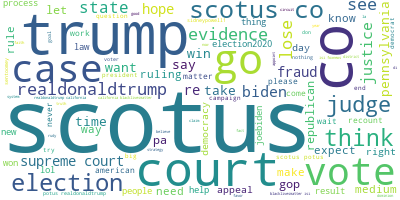

In [32]:
long_string = ','.join(list(tweets['Text_processed'].values))# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=100, contour_width=3, contour_color='steelblue')# Generate a word cloud
wordcloud.generate(long_string)# Visualize the word cloud
wordcloud.to_image()

# Prepare text for LDA analysis

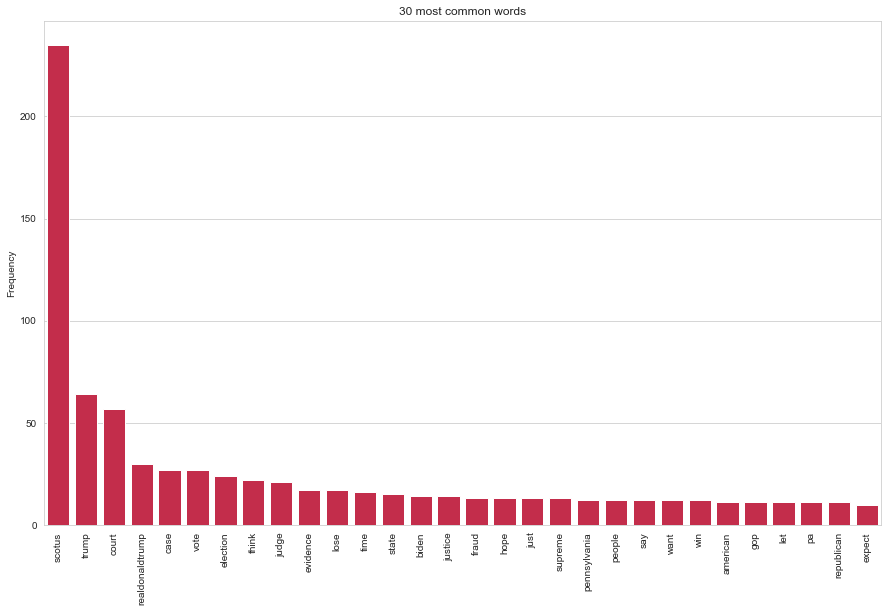

In [33]:
sns.set_style('whitegrid')
%matplotlib inline  
def plot_30_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]   
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:30]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='30 most common words')
    sns.set_context("notebook", font_scale=3, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, color='crimson')
    plt.xticks(x_pos, words, rotation=90) 
    plt.ylabel('Frequency')
    plt.show()# Initialise the count vectorizer with the English stop words   
count_vectorizer = CountVectorizer(stop_words='english')# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(tweets['Text_processed']) # Visualise the 30 most common words
plot_30_most_common_words(count_data, count_vectorizer)

# Total topics

In [34]:
################
##  TOTAL TOPICS
################


total_topics = int(input("Total topics: "))

Total topics: 10


# LDA model training and results visualization

In [35]:
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))       
# Tweak the two parameters below
number_words = 20  # Create and fit the LDA model
lda = LDA(n_components=total_topics, n_jobs=-1)
lda.fit(count_data)

# print("Topics found via LDA:")
# print_topics(lda, count_vectorizer, number_words)

LatentDirichletAllocation(n_jobs=-1)

# Using pyLDAvis with twitter data

In [36]:
# Preparing a corpus for analysis and checking first 5 entries
corpus=[]
a=[]
for i in range(len(tweets['Text_processed'])):
        a=tweets['Text_processed'][i]
        corpus.append(a)  
        
# corpus[0:5]

In [37]:
# create temp folder
TEMP_FOLDER = tempfile.gettempdir()
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
# removing common words and tokenizing
list1 = ['RT','rt']
stoplist = stopwords.words('english') + list(punctuation) + list1
texts = [[word for word in str(document).lower().split() if word not in stoplist] for document in corpus]  # reused in paragraph search below
dictionary = corpora.Dictionary(texts)
dictionary.save(os.path.join(TEMP_FOLDER, 'elon.dict'))  # store the dictionary, for future reference
corpus = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize(os.path.join(TEMP_FOLDER, 'elon.mm'), corpus)  # store to disk, for later
tfidf = models.TfidfModel(corpus) # step 1 -- initialize a model
corpus_tfidf = tfidf[corpus]  # step 2 -- use the model to transform vectors
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tfidf->fold

2020-11-22 22:58:25,746 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-11-22 22:58:25,750 : INFO : built Dictionary(1717 unique tokens: ['arizona', 'clinton', 'dominion', 'kag', 'living']...) from 251 documents (total 3695 corpus positions)
2020-11-22 22:58:25,751 : INFO : saving Dictionary object under C:\Users\61437\AppData\Local\Temp\elon.dict, separately None
2020-11-22 22:58:25,753 : INFO : saved C:\Users\61437\AppData\Local\Temp\elon.dict
2020-11-22 22:58:25,756 : INFO : storing corpus in Matrix Market format to C:\Users\61437\AppData\Local\Temp\elon.mm
2020-11-22 22:58:25,757 : INFO : saving sparse matrix to C:\Users\61437\AppData\Local\Temp\elon.mm
2020-11-22 22:58:25,758 : INFO : PROGRESS: saving document #0
2020-11-22 22:58:25,763 : INFO : saved 251x1717 matrix, density=0.818% (3524/430967)
2020-11-22 22:58:25,764 : INFO : saving MmCorpus index to C:\Users\61437\AppData\Local\Temp\elon.mm.index
2020-11-22 22:58:25,765 : INFO : collecting document frequenc

In [38]:
# Create ordered dictionary
data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}
df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T
# print(df_lda.shape)

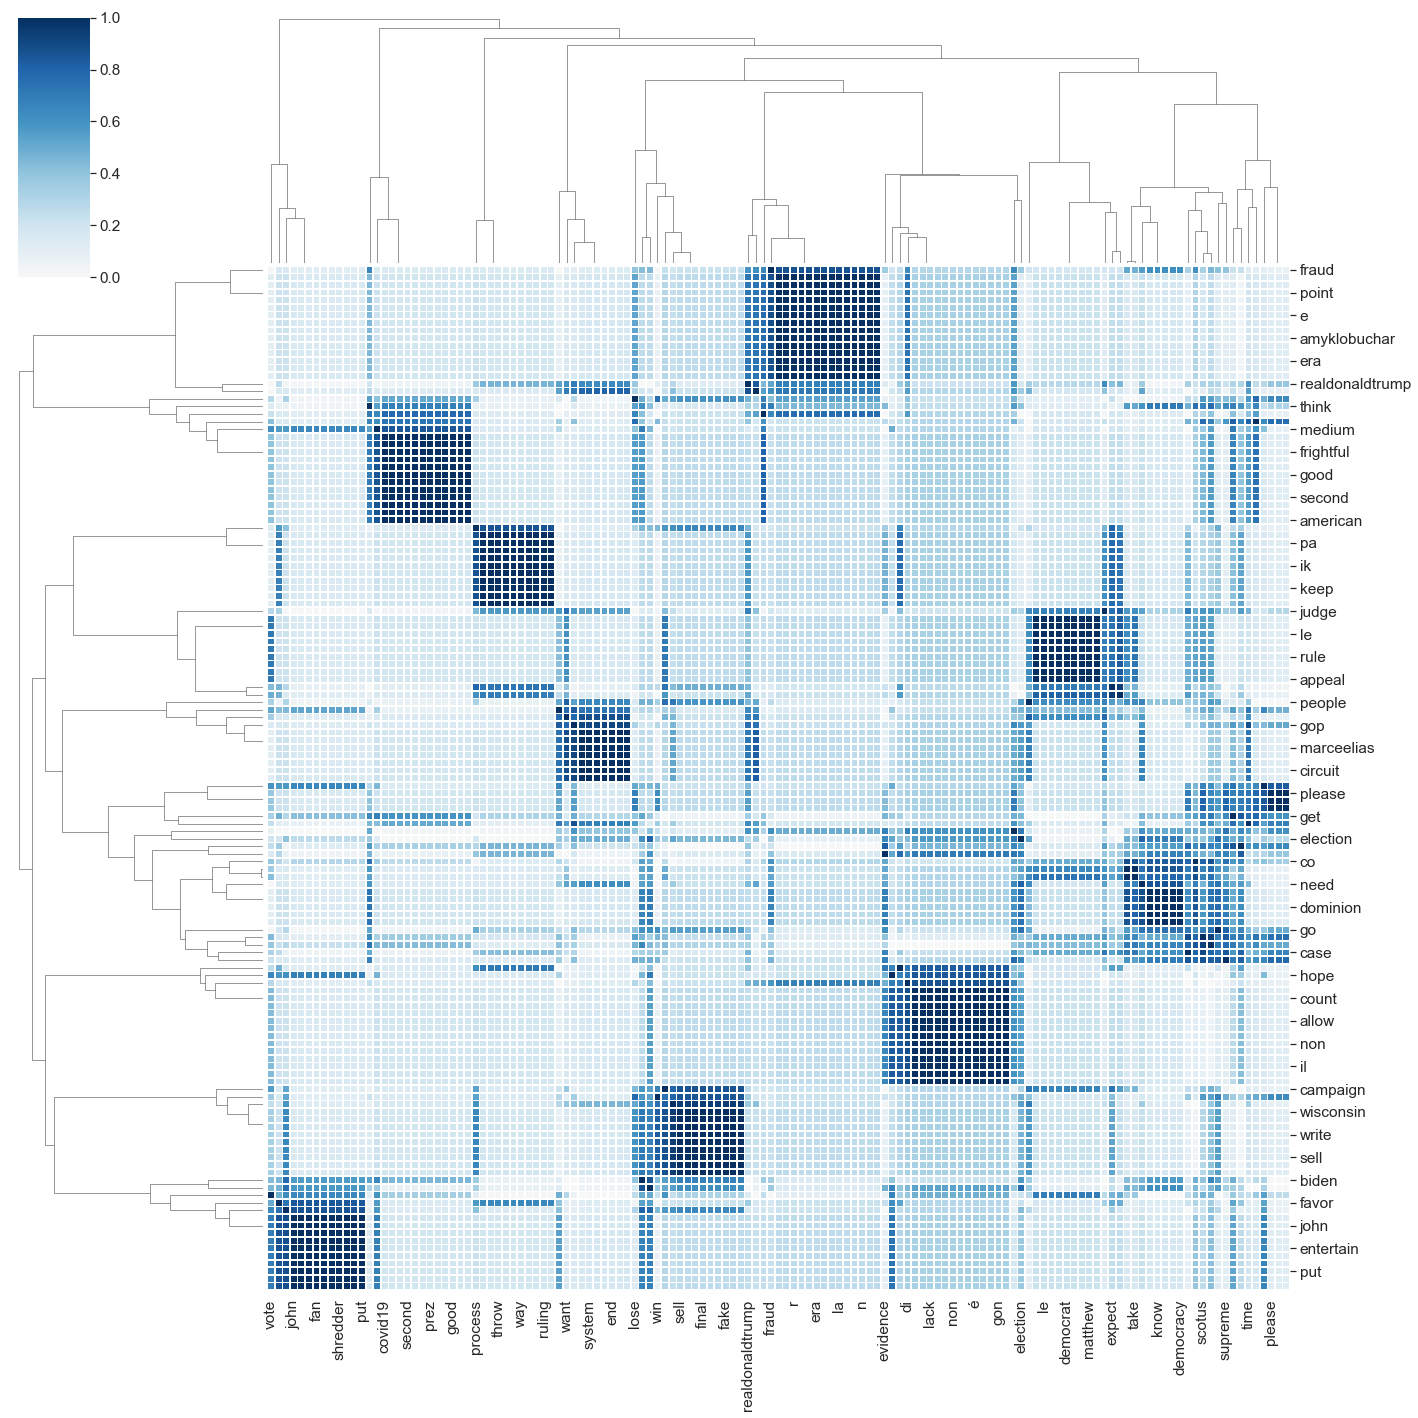

In [39]:
sns.set(font_scale=1.4)
g=sns.clustermap(df_lda.corr(), center=0, standard_scale=1, cmap="RdBu", metric='cosine', linewidths=.75, figsize=(20, 20))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()
#plt.setp(ax_heatmap.get_yticklabels(), rotation=0)  # For y axis

#### Show first n important words in the topics

In [40]:
#Show first n important word in the topics:
lda_list = lda.show_topics(total_topics, 50)
topic_df = pd.DataFrame()
for t in range(total_topics):
    lda_list_n = lda_list[t][1].split(" + ")  # split includes a space around the '+'
    topic_df["Word " + str(t + 1)] = [i.split('*')[1] for i in lda_list_n]
    topic_df["Score " + str(t + 1)] = [i.split('*')[0] for i in lda_list_n]  
    
# topic_df

In [41]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
7      32.420952   8.115230       1        1  54.103499
8       0.648955  71.707100       2        1   5.888268
4      71.019684   9.971006       3        1   5.001383
1       3.785981  33.185135       4        1   5.001240
3     -42.666500  -9.222070       5        1   5.001116
2      -3.621689 -43.526516       6        1   5.001107
5      -3.632402  -4.171708       7        1   5.001079
0     -36.584400  35.804413       8        1   5.000776
6      44.391380  50.615383       9        1   5.000768
9      40.235809 -31.591665      10        1   5.000764, topic_info=         Term       Freq      Total Category  logprob  loglift
8      scotus  11.000000  11.000000  Default  30.0000  30.0000
43         co   5.000000   5.000000  Default  29.0000  29.0000
18        get   1.000000   1.000000  Default  28.0000  28.0000
70      trump   3.000000   3.000000  Default  27.0000  27.0000
82      court   3.000000   3.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
100  election   0.048751   1.735705  Topic10  -5.5509  -0.5769
658       let   0.039315   0.342158  Topic10  -5.7660   0.8319
951      left   0.039637   0.377873  Topic10  -5.7579   0.7408
114   supreme   0.040380   0.773702  Topic10  -5.7393   0.0427
193        go   0.039561   2.382936  Topic10  -5.7598  -1.1027

[616 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
42        1  1.331576         american
271       1  1.058898            biden
328       1  0.602113             case
43        1  0.704930               co
82        1  0.642714            court
212       1  1.008015        democracy
2         1  1.302513         dominion
100       1  0.576135         election
87        1  0.730535         evidence
26        1  1.781019             face
459       1  1.101682            fraud
18        1  0.511957              get
193       1  0.839301               go
236       1  0.966751            judge
901       1  1.315590             know
216       1  0.994484             need
5         1  0.888195     pennsylvania
461       1  1.216001           people
32        1  0.848484  realdonaldtrump
69        1  0.970387       republican
337       1  1.511833            right
208       1  1.313510             rule
8         1  0.618250           scotus
8         2  0.088321           scotus
8         4  0.088321           scotus
8         7  0.088321           scotus
39        1  0.965881              see
233       1  0.899350            state
114       1  1.292487          supreme
178       1  1.079153             take
9         1  0.623925            think
70        1  0.815107            trump, R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 9, 5, 2, 4, 3, 6, 1, 7, 10])

In [66]:
# Sentiment analysis functions

def analyse_corpus_sentiment(text):
    english = spacy.load("en_core_web_sm") 
    negative = []
    neutral = []
    positive = []
    compound = []
    for t in text:
        result = english(t)
        sentences = [str(s) for s in result.sents]
        analyzer = vaderSentiment.SentimentIntensityAnalyzer()
        sentiment = [analyzer.polarity_scores(str(s)) for s in sentences]
        negative.append(sentiment[0]['neg'])
        neutral.append(sentiment[0]['neu'])
        positive.append(sentiment[0]['pos'])
        compound.append(sentiment[0]['compound'])
    sentiment_score = pd.DataFrame()
    sentiment_score['Negative'] = [round(np.mean(negative), 3)]
    sentiment_score['Neutral'] = [round(np.mean(neutral), 3)]
    sentiment_score['Positive'] = [round(np.mean(positive), 3)]
    sentiment_score['Compound'] = [round(np.mean(compound), 3)]
    display(sentiment_score)
    
def sentiment_graph(DAT):
    sentiment_df = pd.DataFrame()
    for d in DAT:
        text_object = NRCLex(str(d))
        sentiment_row = pd.DataFrame.from_dict(text_object.affect_frequencies, orient = 'index').T
        sentiment_df = sentiment_df.append(sentiment_row, ignore_index = True)   
    sentiment_df.mean().sort_values(ascending = False).plot.bar(title = "Mean Sentiment Score")

# Phrase search

In [77]:
###############
# PHRASE SEARCH
###############


search_word = "hope"

subset_search_word = ""


# duplicate original data for search function and sentiment analysis
text_dat = tweets_original['Text'] 
# convert to lower case for search function
comments_lower = pd.DataFrame()
comments_lower['comment'] = text_dat.apply(lambda row: row.lower())  
searched_comment = comments_lower[(comments_lower['comment'].str.contains(search_word)) & 
                                  (comments_lower['comment'].str.contains(subset_search_word))] 
# Join index of 'searched_comment' with original data to restore punctuation and upper case
searched_comment_index = searched_comment.index.tolist()
sci = pd.DataFrame()
sci['index'] = searched_comment_index
sci.set_index('index', inplace = True)
searched_comment_joined = pd.merge(sci, text_dat, left_on = 'index', right_index = True)
# Remove quotation marks (“”) from text for sentiment analysis
searched_comments_tidied = searched_comment_joined.Text.map(lambda x: re.sub('[“”]', "", x))  

Searched comment length:  13



,Negative,Neutral,Positive,Compound
0,0.071,0.886,0.043,-0.017


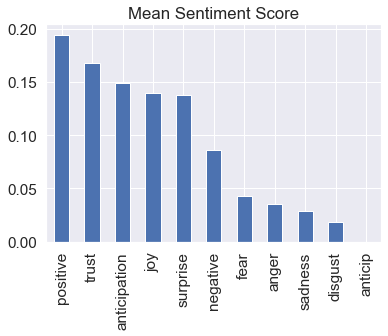

In [78]:
print("Searched comment length: ", len(searched_comment_joined))
print("")
analyse_corpus_sentiment(searched_comments_tidied)
print("")
sentiment_graph(searched_comments_tidied)

In [79]:
pd.set_option('max_colwidth',600)

if len(searched_comment_joined) <= 50:
    display(searched_comment_joined.head(50))
else:
    display(searched_comment_joined.sample(n = 50).sort_values(by = 'index', ascending = True, inplace = False))

,Text
index,
6,"#scotus \n#potus \n#realdonaldtrump\n#gop \n#dnc \n#california \n#antifa \n#blacklivesmatter \n#isis \n#foxnews \n#cnn \n#joebiden \n#speakerpelosi \n#un \n\ni hope you had enough time for what i have have shred so far to ""sink in"".\n\nit is not a good thing at all, in any way!"
15,"so is the #scotus going to get a chance to laugh hysterically at the #trump ""evidence"" (😂😂😂😂)?\n\ni really, really hope so.\n\n#trumpmeltdown #trumpisanationaldisgrace #trumpispathetic #trumpisacriminal https://t.co/w2jrzsawsh"
48,course you'll appeal. your only gambit has always been to get this nonsense in front of your crony-packed #scotus and hope that they will prostitute their integrity and us democracy to appease your tantrum. https://t.co/dejm73d2lv
62,he’s trying to push through as the media and democrats hope the courts block you from succeeding in exposing the vast fraud and corruption. get this to #scotus asap mr. president https://t.co/opwxymbvmu
63,@bravenew_orwell @readingpets hopefully with @sidneypowell1 we can bring it all down. #draintheswamp let’s hope the deep state doesn’t threaten our #scotus judges
65,@realdonaldtrump \nstfu donnie—your strategy’s failing fast. \nyou lost the fvcking election—you’re living in the past. \nthe #scotus won’t enable you—like the flaccid #gop\nget out of the fvcking wh—you malignant sob. \n\n#trumpout #hope 👊 https://t.co/tzmnwpxbqb
71,the #scotus strategy isn’t working.\n“this is simply not how the constitution works” \njudge matthew brann \n\n—re trump campaign’s push to stop pennsylvania certifying the election results. 👊 #hope
82,because that's just what criminals &amp; cheaters do. they just forge ahead as if nothing happened and nobody can touch them\n\nwhether this goes to state legislatures or even #scotus ... we all hope &amp; pray the truth is allowed to be heard https://t.co/xudyzpuewn
188,@sentoomey i hope you show the same reverence to #scotus


In [80]:
index_num = 152

if index_num in searched_comment_joined.index: display(searched_comment_joined.Text.loc[index_num])